
References:

[1] Hector Morrell and Hiu Yung Wong, "Step-by-Step HHL Algorithm Walkthrough to Enhance the Understanding of Critical Quantum Computing Concepts", arXiv preprint arXiv:2108.09004


In [77]:
# Imports for Qiskit
from qiskit.compiler import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
# various imports
import numpy as np
from matplotlib import pyplot as plt



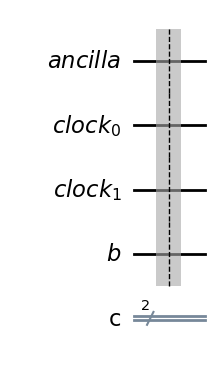

In [78]:
# Create the various registers needed
c_qubits = 2
clock = QuantumRegister(c_qubits, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)
circuit.barrier()
circuit.draw(output='mpl')

In [79]:
def qpe(circ, clock, target):
    circ.barrier()

    # e^{i*A*t}
    circ.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');
    
    # e^{i*A*t*2}
    circ.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    circ.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    circ.compose(
    QFT(c_qubits, inverse=True), clock,
    inplace=True)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    circ.compose(
    QFT(c_qubits, inverse=False), clock,
    inplace=True)

    circ.barrier()

    # e^{-i*A*t*2}
    circ.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{-i*A*t}
    circ.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    circ.barrier()

In [80]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    circuit.barrier()
    
    # This section is to test and implement C = 1
    circ.cry(np.pi, clock[0], ancilla)
    circ.cry(np.pi/3, clock[1], ancilla)

    #deferred measurement principle
    #circuit.measure(ancilla, measurement[0])
    circuit.barrier()
    inv_qpe(circ, clock, input)

In [81]:
# State preparation. 
intial_state = [0,1]
circuit.initialize(intial_state, 3)

circuit.barrier()

# Perform a Hadamard Transform
circuit.h(clock)

hhl(circuit, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()

circuit.measure(ancilla, measurement[0])
circuit.measure(input, measurement[1])

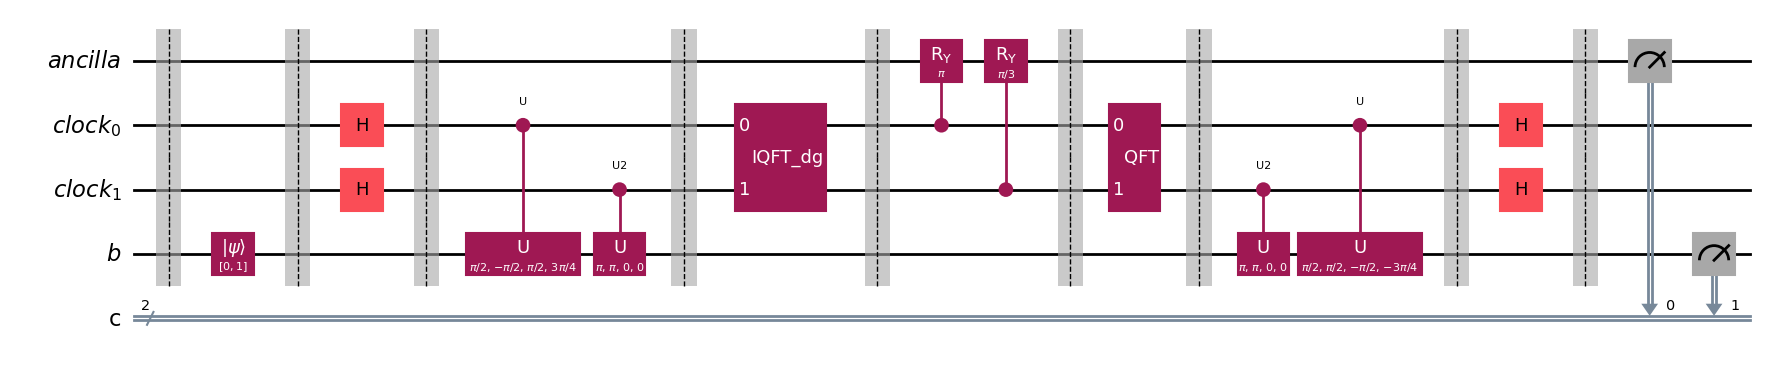

In [82]:
circuit.draw('mpl', scale=1)

In [83]:
# Execute the circuit using the simulator
from qiskit_aer import AerSimulator
simulator = AerSimulator()
circuit_compiled = transpile(circuit, simulator)
job_sim = simulator.run(circuit_compiled, shots=10000)

#Get the result of the execution
result_sim = job_sim.result()

# Get the counts, the frequency of each answer
counts = result_sim.get_counts(circuit_compiled)

# Display the results
plot_histogram(counts)
x1_count = counts['01'] #ancilla is 1, b is 0
x2_count = counts['11'] #ancilla is 1, b is 1
print(x2_count/x1_count)

9.480801335559265


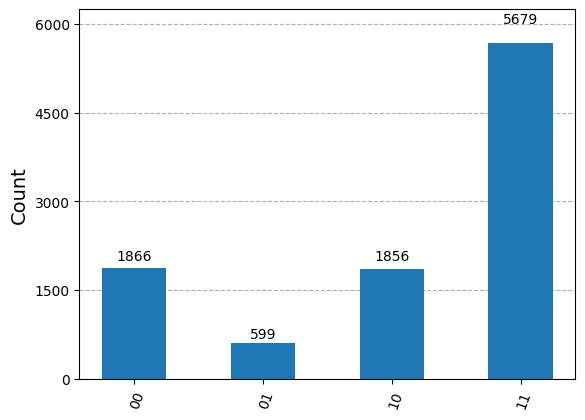

In [84]:
# Display the results
plot_histogram(counts)

In [90]:
circuit.remove_final_measurements()  # no measurements allowed to print the statevector
from qiskit.quantum_info import Statevector
statevector = Statevector(circuit)

s = ""
for state, amp in enumerate(statevector.data):
    if not np.isclose(amp, 0):
        s += f"+ ({amp:.2f})|{state:0{statevector.num_qubits}b}⟩ "
print(s)



NameError: name 'sv' is not defined